In [1]:
from fastai.vision import *
from fastai.datasets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torchvision as ptv
from utils.blocks import *
from utils.clr import *

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
from scipy import signal

In [2]:
use_cuda = torch.cuda.is_available(); print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
CUDA_LAUNCH_BLOCKING=1
%matplotlib inline
%reload_ext autoreload
%autoreload 2

True


In [3]:
bs = 64
sz = 28

In [4]:
dataPATH/"testing"

NameError: name 'dataPATH' is not defined

In [5]:
PATH = Path("../data/mnist")
train = MNIST(PATH, train=True, transform=ptv.transforms.ToTensor())
val = MNIST(PATH, train=False, transform=ptv.transforms.ToTensor())

trn_dl = DataLoader(train, batch_size=bs)
val_dl = DataLoader(val, batch_size=bs)

In [6]:
trn_dl.dataset.train_data

# path = url2path(URLs.MNIST_SAMPLE)
# tfms = (rand_pad(2, 28), [])
# data = ImageDataBunch.from_folder(path, ds_tfms=tfms, bs=64).normalize(imagenet_stats)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [6]:
# import pdb
class Dense_CVAE(nn.Module):
    def __init__(self,n_lat,lat_chan,init="standard",dense=True):
        super().__init__()
        self.n_lat = n_lat
        self.lat_chan = lat_chan
        self.z_shape = sz//2**3 +1
        self.h_dim = lat_chan * self.z_shape**2
        self.dense = dense
        
        #encoder
        self.ddense1 = DenseBlock(1, self.lat_chan*2)
        self.dconv1 = StdConv(1, self.lat_chan*2,2,2,init=init)
        if self.dense: self.dconv1 = StdConv(self.lat_chan*2, self.lat_chan*2,2,2,init=init)
         
        #channels = 128
        
        self.ddense2 = DenseBlock(self.lat_chan*2, self.lat_chan*2)
        self.dconv2 = StdConv(self.lat_chan*2, self.lat_chan*2,2,2,1,init=init)
        #channels = 128
        
        self.ddense3 = DenseBlock(self.lat_chan*2, self.lat_chan*2)
        self.dconv3 = StdConv(self.lat_chan*2, self.lat_chan, 2,2,init=init)
        #channels = 64
        
        #q
        self.q_mean = StdLinear(self.h_dim, self.n_lat)
        self.q_logvar = StdLinear(self.h_dim, self.n_lat)
        self.q_project = StdLinear(self.n_lat, self.h_dim)
        
        #decoder
        self.udense1 = DenseBlock(self.lat_chan*2, self.lat_chan*2)
        self.uconv1 = StdUpsample(self.lat_chan*2, self.lat_chan, 2,2)
        
        self.udense2 = DenseBlock(self.lat_chan*3, self.lat_chan*3)
        self.uconv2 = StdUpsample(self.lat_chan*3, self.lat_chan*2,2,2,1)
        
        self.udense3 = DenseBlock(self.lat_chan*4,self.lat_chan*4)
        self.uconv3 = StdUpsample(self.lat_chan*4, 1,2,2)
        
#         self.udense4 = DenseBlock(self.lat_chan*4,1)
        
    def encode(self,x):
        if self.dense: x = self.ddense1(x)
        x = self.dx1 = self.dconv1(x)
        if self.dense: x = self.ddense2(x)
        x = self.dx2 = self.dconv2(x)
        if self.dense: x = self.ddense3(x)
        x = self.dx3 = self.dconv3(x)
        return x.view(x.size(0), -1)
    
    def z(self, flattened):
        self.mean, self.logvar = self.q_mean(flattened), self.q_logvar(flattened)
        std = self.logvar.mul(.5).exp_()
        eps =  (torch.randn(std.size())).cuda()
        return eps.mul(std).add_(self.mean)
    
    def decode(self,z):
        z = self.q_project(z).view(-1, self.lat_chan, self.z_shape, self.z_shape)
        z = torch.cat([z,self.dx3],dim=1)
        if self.dense: z = self.udense1(z)
        z = self.uconv1(z)
        z = torch.cat([z,self.dx2],dim=1)
        if self.dense: z = self.udense2(z)
        z = self.uconv2(z)
        z = torch.cat([z,self.dx1],dim=1)
        if self.dense: z = self.udense3(z)
        z = self.uconv3(z)
#         z = self.udense4(z)
        return z
    
    def forward(self, x):
        x = self.encode(x)
        z = self.z(x)
        y = self.decode(z)
        return (y, (self.mean, self.logvar))

In [10]:
class Conv_id_bow_VAE(nn.Module):
    def __init__(self,n_lat,lat_chan,init="standard"):
        super().__init__()
        self.n_lat = n_lat
        self.lat_chan = lat_chan
        self.z_shape = sz//2**3 +1
        self.h_dim = lat_chan * self.z_shape**2
        
        #encoder
        self.dconv1 = StdConv(1, self.lat_chan*3,2,2,init=init)
         
        #channels = 128
       
        self.dconv2 = StdConv(self.lat_chan*3, self.lat_chan*2,2,2,1,init=init)
        #channels = 128
       
        self.dconv3 = StdConv(self.lat_chan*2, self.lat_chan, 2,2,init=init)
        #channels = 64
        
        #q
        self.q_mean = StdLinear(self.h_dim, self.n_lat)
        self.q_logvar = StdLinear(self.h_dim, self.n_lat)
        self.q_project = StdLinear(self.n_lat, self.h_dim)
        
        #decode
        self.uconv1 = StdUpsample(self.lat_chan*2, self.lat_chan, 2,2)
       
        self.uconv2 = StdUpsample(self.lat_chan*3, self.lat_chan*2,2,2,1)
       
        self.uconv3 = StdUpsample(self.lat_chan*5, 1,2,2)
        
    def encode(self,x):
        x = self.dx1 = self.dconv1(x)
        x = self.dx2 = self.dconv2(x)
        x = self.dx3 = self.dconv3(x)
        return x.view(x.size(0), -1)
    
    def z(self, flattened):
        self.mean, self.logvar = self.q_mean(flattened), self.q_logvar(flattened)
        std = self.logvar.mul(.5).exp_()
        eps = torch.randn(std.size()).cuda()
        return eps.mul(std).add_(self.mean)
    
    def decode(self,z):
        z = self.q_project(z).view(-1, self.lat_chan, self.z_shape, self.z_shape)
        z = torch.cat([z,self.dx3],dim=1)
        # channels =  
        z = self.uconv1(z)
        z = torch.cat([z,self.dx2],dim=1)
        z = self.uconv2(z)
        z = torch.cat([z,self.dx1],dim=1)
        z = self.uconv3(z)
        return z
    
    def forward(self, x):
        x = self.encode(x)
        z = self.z(x)
        y = self.decode(z)
        return (y, (self.mean, self.logvar))

In [8]:
class Conv_bow_VAE(nn.Module):
    def __init__(self,n_lat,lat_chan,init="standard"):
        super().__init__()
        self.n_lat = n_lat
        self.lat_chan = lat_chan
        self.z_shape = 7
        self.h_dim = lat_chan * self.z_shape**2
        
        #encoder
        self.dconv1 = StdConv(1, self.lat_chan*3,2,2,init=init)
       
        self.dconv2 = StdConv(self.lat_chan*3, self.lat_chan*2,2,2,1,init=init)
       
        self.dconv3 = StdConv(self.lat_chan*2, self.lat_chan, 2,2,init=init)
        
        #q
        self.q_mean = StdLinear(self.h_dim, self.n_lat)
        self.q_logvar = StdLinear(self.h_dim, self.n_lat)
        self.q_project = StdLinear(self.n_lat, self.h_dim)
        
        #decode
        self.uconv1 = StdUpsample(self.lat_chan, self.lat_chan*2, 2,2)
       
        self.uconv2 = StdUpsample(self.lat_chan*2, self.lat_chan*3,2,2,1)
       
        self.uconv3 = StdUpsample(self.lat_chan*3, 1,2,2)
        
    def encode(self,x):
        x = self.dx1 = self.dconv1(x)
        x = self.dx2 = self.dconv2(x)
        x = self.dx3 = self.dconv3(x)
        return x.view(x.size(0), -1)
    
    def z(self, flattened):
        self.mean, self.logvar = self.q_mean(flattened), self.q_logvar(flattened)
        std = self.logvar.mul(.5).exp_()
        eps = torch.randn(std.size()).cuda()
        return eps.mul(std).add_(self.mean)
    
    def decode(self,z):
        z = self.q_project(z).view(-1, self.lat_chan, self.z_shape, self.z_shape)
        z = self.uconv1(z)
        z = self.uconv2(z)
        z = self.uconv3(z)
        return z
    
    def forward(self, x):
        x = self.encode(x)
        z = self.z(x)
        y = self.decode(z)
        return (y, (self.mean, self.logvar))

In [20]:
class Conv_dia_VAE(nn.Module):
    def __init__(self,n_lat,lat_chan,init="standard"):
        super().__init__()
        self.n_lat = n_lat
        self.lat_chan = lat_chan
        self.z_shape = sz//2**2
        self.h_dim = lat_chan * self.z_shape**2
        
        #encoder
        self.dconv1 = StdConv(1, self.lat_chan//2,2,2,init=init)
       
        self.dconv2 = StdConv(self.lat_chan//2, self.lat_chan,2,2,init=init)
        
        #q
        self.q_mean = StdLinear(self.h_dim, self.n_lat)
        self.q_logvar = StdLinear(self.h_dim, self.n_lat)
        self.q_project = StdLinear(self.n_lat, self.h_dim,False)
        
        #decode
       
        self.uconv2 = StdUpsample(self.lat_chan*2, self.lat_chan,2,2)
        self.uconv3 = StdUpsample(self.lat_chan, 1,2,2)
        
    def encode(self,x):
        x = self.dx1 = self.dconv1(x)
        x = self.dx2 = self.dconv2(x)
#         x = self.dx3 = self.dconv3(x)
#         print(x.shape)
        return x.view(x.size(0), -1)
    
    def z(self, flattened):
#         print(flattened.shape)
        self.mean, self.logvar = self.q_mean(flattened), self.q_logvar(flattened)
        std = self.logvar.mul(.5).exp_()
        eps = torch.randn(std.size()).cuda()
#         print(eps.mul(std).add_(self.mean).shape)
        return eps.mul(std).add_(self.mean)
    
    def decode(self,z):
        z = self.q_project(z).view(-1, self.lat_chan, self.z_shape, self.z_shape)
        z = torch.cat([z,self.dx2],dim=1)
#         print(z.shape)
#         z = self.uconv1(z)
        z = self.uconv2(z)
        z = self.uconv3(z)
        return torch.sigmoid(z)
    
    def forward(self, x):
        x = self.encode(x)
        z = self.z(x)
        y = self.decode(z)
        return (y, (self.mean, self.logvar))

In [8]:
def append_stats(ep_vals, epoch, values, decimals=6):
    ep_vals[epoch]=list(np.round(values, decimals))
    return ep_vals

def print_stats(epoch, values, decimals=3):
    layout = "{!s:^10}" + " {!s:10}" * len(values)
    values = [epoch] + list(np.round(values, decimals))
    print(layout.format(*values))

def save_checkpoint(name, filename, is_best):
    state = {'epoch': epochs,
            'last_epoch': epoch,
            'arch': filename,
            'state_dict': net.state_dict(),
            'losses': [t_ls,v_ls],
            'optimizer': optim.state_dict(),
            'scheduler': scheduler.__dict__}

    torch.save(state, f'../data/checks/{filename}')
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
    print('Checkpoint saved.')

def vae_loss(pred, targ, mean, logvar):
    kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    recon = loss(pred, targ)
    return kl + recon
    
names = ["ep / it","trn_loss", 'recon_loss','kl_loss',"val_loss"]
# names = ["ep / it", "trn_loss","lwst_trn","val_loss","accuracy"]
layout = "{!s:10} " * len(names)

In [11]:
n_lat = 8
lat_chan = 32
epochs = 1
params = {'size': sz,
          'batch size': bs,
          'n_lat': n_lat,
          'lat_chan': lat_chan,
          'total_epochs':epochs}
net2 = Conv_bow_VAE(n_lat,lat_chan,init="xavier")
net1 = Conv_id_bow_VAE(n_lat,lat_chan,init="xavier")
# net2 = Conv_dia_VAE(n_lat,lat_chan,init="xavier")
# net = VAE(n_lat)
nets = [(f"CVAE_id_bow-{n_lat}x{lat_chan}",net1),(f"CVAE_dense-{n_lat}x{lat_chan}",net2)]


In [51]:
chans = [(8,32),(8,16),(4,32),(4,16)]
nets=[]
for n_lat, lat_chan in chans:
    epochs = 1
    params = {'size': sz,
          'batch size': bs,
          'n_lat': n_lat,
          'lat_chan': lat_chan,
          'total_epochs':epochs}
    
    
    net1 = Conv_id_bow_VAE(n_lat,lat_chan,init="xavier")
    net2 = Conv_dia_VAE(n_lat,lat_chan,init="xavier")
    nets.append((f"CVAE_id_bow-{n_lat}x{lat_chan}",net1))
#     nets.append((f"CVAE_dense-{n_lat}x{lat_chan}",net2))

In [52]:

if use_cuda:
    [net.cuda() for _,net in nets]
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    
lr = 2e-6

optim = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.MSELoss()

scheduler = CyclicLR(optim, lr, mode='triangular2', step_size=len(train)//2)
window = 200

In [53]:
optim = torch.optim.Adam(net.parameters(), lr=lr)
scheduler = CyclicLR(optim, lr, mode='triangular2', step_size=len(train)*2)

CVAE_id_bow-8x32
ep / it    trn_loss   recon_loss kl_loss    val_loss   
  1 / 1    5.3864     0.2036     4.319      0.3275    
 1 / 201   2.4336     0.1848     1.874      0.3396    
 1 / 401   0.2323     0.1162     0.0967     0.0756    
 1 / 601   0.0772     0.0658     0.0095     0.0304    
 1 / 801   0.0326     0.0287     0.0032     0.013     
Checkpoint saved.
CVAE_id_bow-8x16
ep / it    trn_loss   recon_loss kl_loss    val_loss   
  1 / 1    7.3264     0.3217     5.8373     0.455     
 1 / 201   4.9299     0.3084     3.8513     2.0407    
 1 / 401   0.955      0.2227     0.6103     0.1685    
 1 / 601   0.2047     0.1298     0.0624     0.0805    
 1 / 801   0.098      0.0819     0.0135     0.0493    
Checkpoint saved.
CVAE_id_bow-4x32
ep / it    trn_loss   recon_loss kl_loss    val_loss   
  1 / 1    0.9415     0.1069     0.6955     0.1465    
 1 / 201   0.4197     0.1109     0.2573     0.1155    
 1 / 401   0.1149     0.102      0.0108     0.086     
 1 / 601   0.0866     0.0848  

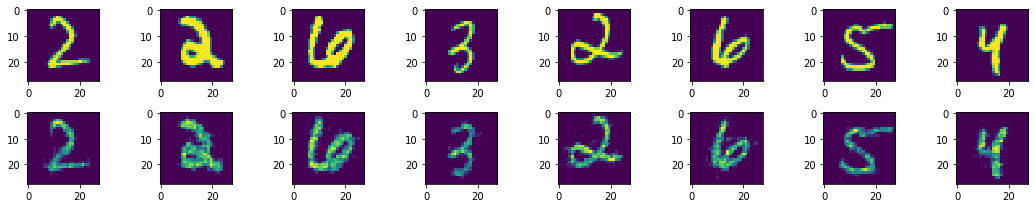

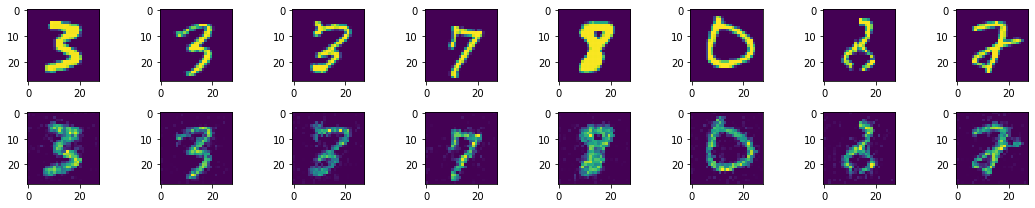

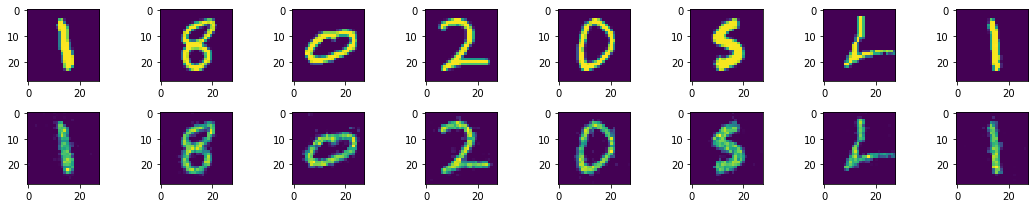

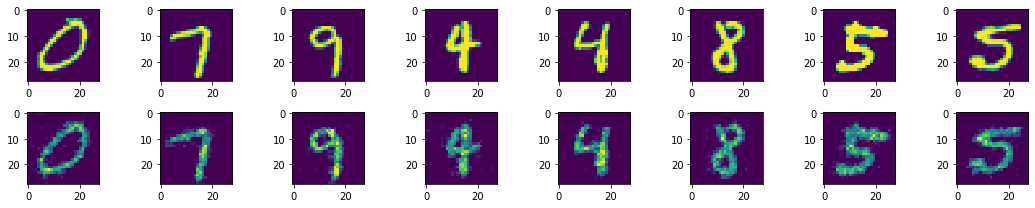

In [54]:
for (name,net) in nets:
    t_ls = []
    r_ls = []
    k_ls = []
    v_ls = []
    accs = []
    ep_vals = OrderedDict()
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = CyclicLR(optim, lr, mode='triangular2', step_size=len(train)//2)
    print(name)
    for epoch in range(epochs):
        if epoch == 0: print(layout.format(*names))
        val_it = iter(val_dl)
        for i, (batch, ys) in enumerate(trn_dl, 0):
            scheduler.batch_step()        
            batch = batch.type(dtype)
            ys = ys.type(dtype)
            net.train()
            pred, (mean, logvar) = net(batch)
    #         ls = loss(pred, ys)
            kl = -0.2 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    #         assert (input >= 0. & input <= 1.).all()
            recon = loss(pred, batch)
            ls = kl*1.2 + recon 
    #         ls = vae_loss(pred, batch, mean, logvar)
            optim.zero_grad()
            ls.backward()
            t_ls.append(ls.item())
            r_ls.append(recon.item())
            k_ls.append(kl.item())
            optim.step()
            vals = [np.mean(t_ls[-window:]), np.mean(r_ls[-window:]), np.mean(k_ls[-window:])]

            if i % window == 0:
                net.eval()
                with torch.no_grad():
                    v_bat, v_ys = next(val_it)

                    v_bat = v_bat.type(dtype)
                    v_ys = v_ys.type(dtype)
                    v,( mean, logvar) = net(v_bat)
                    v_loss = vae_loss(v, v_bat, mean, logvar)
                    v_ls.append(v_loss.item())
    #                 accs.append(accuracy(v.long(), v_bat.cuda.long()))


                min_t_l = np.min(t_ls[-window:])
                vals.append(v_loss.item())
    #             vals.extend((min_t_l, v_loss.item(), accs[-1]))
    #             vals.extend((v_loss.item(), np.mean(accs[-3:])))
                print_stats(f"{epoch+1} / {i+1}",vals,4)
        display_recon() #; display_gen()
        save_checkpoint('dense_vae', name, False)
        ep_vals = append_stats(ep_vals, epoch+1, vals)
        

In [56]:
??save_checkpoint('CVAE_dia_1', False)

In [25]:
g = iter(val_dl)

In [67]:
def generate(bs=bs,mode=None):
#     vx = torch.FloatTensor([np.random.normal(0, 1, sz**2) for _ in range(bs)]).cuda()
#     vx = torch.FloatTensor([np.random.normal(0,7,7) for _ in range(bs)]).cuda()
    vx = torch.FloatTensor([np.random.normal(0, 1, 1024) for _ in range(bs)]).cuda()
    vx = vx.view(-1,1,32,32)
    net = nets[2][1].eval()
#         vx = Variable(torch.randn(bs,params["sz"]**2,dtype=torch.float, device="cuda")).view(-1,1,params["sz"],params["sz"])
    return net(vx)

def display_recon(g=iter(val_dl),bs=8):
    x, _ = next(g)
    x = x.type(dtype)
    vx = x[:bs]
    z_im, _= net(vx)
    z_im = z_im.data.cpu().numpy().reshape(-1,28,28)*255.
    fig, axes = plt.subplots(2, bs, figsize=(15,3))
    for ax, im in enumerate(x[:bs]):
        axes[0,ax].imshow(im[0,:,:])
        axes[1,ax].imshow(z_im[ax])
    plt.tight_layout()
    
def display_gen(bs=16, mode=0):
    if mode == 0:
        ims,_ = generate(bs, mode)
    else:
        ims = generate(bs, mode)
    ims = ims.data.cpu().numpy()
    ims = ims.reshape(-1,28,28)*255.
    plt.figure(figsize=(15,3))
    for i, im in enumerate(ims):
        plt.subplot(2,bs/2,i+1)
        plt.imshow(im)
    plt.tight_layout()

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 9 and 8 in dimension 2 at /pytorch/aten/src/THC/generic/THCTensorMath.cu:71

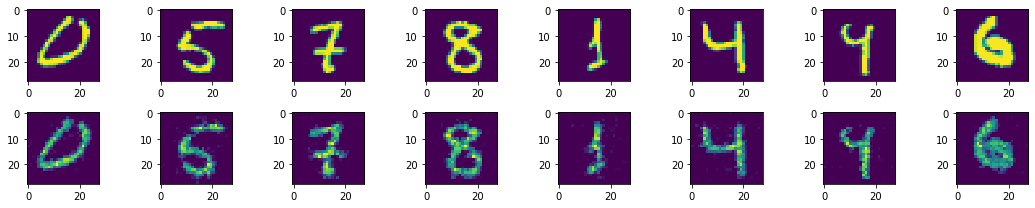

In [68]:
display_recon(g); display_gen()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


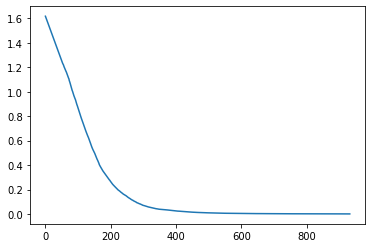

In [57]:
data= k_ls[:-5]
x = range(len(data))
y = data
# plt.title(f'{net.base}_{net.sub}_{net.n_layers}x{net.start_dim}')
plt.plot(x, signal.savgol_filter(y,101,1))
plt.show()

In [ ]:
batch[0].shape

In [21]:
ba, _ = next(g)
ba[0]

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0